<a href="https://colab.research.google.com/github/apthagowda97/pytorch_poc/blob/master/mask_rcnn/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell

wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip > /dev/null

--2020-08-23 17:31:22--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  1008KB/s    in 48s     

2020-08-23 17:32:10 (1.07 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2020-08-23 17:32:10--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-08-23 17:32:10--
Total wall clock time: 48s
Downloaded: 1 files, 51M in 48s (1.07 MB/s)


In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

%matplotlib inline

In [36]:
def plot(image_names,title=None):
  for i,name in enumerate(image_names): 
    plt.subplot(1,len(image_names),i+1)
    image = plt.imread(name)
    plt.imshow(image);plt.axis('off')
    if title!=None:plt.title(title[i])

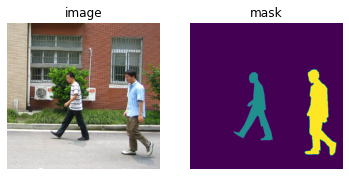

In [37]:
plot(['PennFudanPed/PNGImages/FudanPed00001.png','PennFudanPed/PedMasks/FudanPed00001_mask.png'],['image','mask'])

In [39]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)

        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [41]:
dataset = PennFudanDataset('PennFudanPed/')

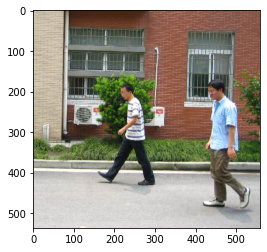

In [58]:
image,target = dataset[0]
plt.imshow(image)

In [57]:
print(target.keys())

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])


In [63]:
target['masks'].shape

torch.Size([2, 536, 559])